# Number Recognizer

今回は、ブラウザ上に書いた手書きの数字を認識させます。具体的には、canvasに書かれた数字が0～9のどれであるかを当てさせます。  
その予測を行うためのモデルを、以下のステップに沿って作成していきます。


* [データロード](#Load-the-Data)
* [モデル構築](#Create-the-Model)
* [学習](#Training-the-Model)
* [評価](#Evaluate-the-Model)
* [保存](#Store-the-Model)


In [17]:
# グラフが文章中に表示されるようにするおまじない
%matplotlib inline

## Load the Data

scikit-learnには、最初から手書きの数字を認識するための学習データ(手書き数字の画像データと、その画像の数字が0～9の何れであるかという答えのセット)が搭載されているため、それを利用します。

In [27]:
def load_data():
    from sklearn import datasets
    dataset = datasets.load_digits()
    return dataset

digits = load_data()
print(digits.data.shape)

(1797, 64)


`1797`は行数、`64`は次元数です。手書き文字の画像データが8×8のサイズであるため、その中のピクセル情報は64となります(今回値はグレースケールですが、RGBの場合3倍になります)。

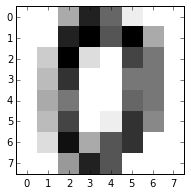

In [28]:
def show_image(image):
    import matplotlib.pyplot as plt

    plt.figure(1, figsize=(3, 3))
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()

show_image(digits.images[0])

## Create the Model

今回扱うのは画像の分類問題になります。そこで、シンプルな線形分類機であるSGDClassifierを利用します。

In [29]:
def make_model():
    from sklearn.linear_model import SGDClassifier    
    clf = SGDClassifier(alpha=0.0001, fit_intercept=True, n_iter=200)
    return clf
    
classifier = make_model()

## Training the Model

データとモデルがそろったため、学習させてみます。

In [30]:
def split_dataset(dataset, test_size=0.3):
    from sklearn import cross_validation
    from collections import namedtuple

    DataSet = namedtuple("DataSet", ["data", "target"])
    train_d, test_d, train_t, test_t = cross_validation.train_test_split(dataset.data, dataset.target, test_size=test_size, random_state=0)

    left = DataSet(train_d, train_t)
    right = DataSet(test_d, test_t)

    return left, right

# use 30% of data to test the model
training_set, test_set = split_dataset(digits, 0.3)
print("dataset is splited to train/test = {0} -> {1}, {2}".format(
        len(digits.data), len(training_set.data), len(test_set.data))
     )

dataset is splited to train/test = 1797 -> 1257, 540


In [31]:
classifier.fit(training_set.data, training_set.target)

/Users/taku/.pyenv/versions/miniconda3-3.16.0/envs/ml_env/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=200, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [32]:
def tuning_model(model_func, dataset):
    from sklearn.grid_search import GridSearchCV

    candidates = [
        {"loss": ["hinge", "log"],
         "alpha": [1e-5, 1e-4, 1e-3]
        }]

    searcher = GridSearchCV(model_func(), candidates, cv=5, scoring="f1_weighted")
    searcher.fit(dataset.data, dataset.target)

    for params, mean_score, scores in sorted(searcher.grid_scores_, key=lambda s: s[1], reverse=True):
        print("%0.3f (+/-%0.03f) for %r" % (mean_score, scores.std() / 2, params))

    return searcher.best_estimator_

classifier = tuning_model(make_model, digits)

/Users/taku/.pyenv/versions/miniconda3-3.16.0/envs/ml_env/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/taku/.pyenv/versions/miniconda3-3.16.0/envs/ml_env/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/taku/.pyenv/versions/miniconda3-3.16.0/envs/ml_env/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/taku/.pyenv/versions/miniconda3-3.16.0/envs/ml_env/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(in

0.906 (+/-0.013) for {'loss': 'hinge', 'alpha': 0.001}
0.904 (+/-0.018) for {'loss': 'log', 'alpha': 0.001}
0.903 (+/-0.014) for {'loss': 'hinge', 'alpha': 0.0001}
0.898 (+/-0.015) for {'loss': 'hinge', 'alpha': 1e-05}
0.896 (+/-0.014) for {'loss': 'log', 'alpha': 0.0001}
0.896 (+/-0.015) for {'loss': 'log', 'alpha': 1e-05}


/Users/taku/.pyenv/versions/miniconda3-3.16.0/envs/ml_env/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/taku/.pyenv/versions/miniconda3-3.16.0/envs/ml_env/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


## Evaluate the Model

学習させたモデルの精度を計測してみます。`predict`で予測させることができるので、これで予測させた値と実際の答え(`digits.target`)を比べてみます。

In [33]:
def calculate_accuracy(model, dataset):
    from sklearn import metrics

    predicted = model.predict(dataset.data)
    score = metrics.accuracy_score(dataset.target, predicted)
    return score

print(calculate_accuracy(classifier, training_set))
print(calculate_accuracy(classifier, test_set))

0.985680190931
0.977777777778


## Store the Model

最後に、学習させたモデルを保存します。アプリケーション側で、その結果を確認してみてください。

In [34]:
from sklearn.externals import joblib

joblib.dump(classifier, "./machine.pkl") 

['./machine.pkl',
 './machine.pkl_01.npy',
 './machine.pkl_02.npy',
 './machine.pkl_03.npy',
 './machine.pkl_04.npy']

/Users/taku/.pyenv/versions/miniconda3-3.16.0/envs/ml_env/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/taku/.pyenv/versions/miniconda3-3.16.0/envs/ml_env/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/taku/.pyenv/versions/miniconda3-3.16.0/envs/ml_env/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/taku/.pyenv/versions/miniconda3-3.16.0/envs/ml_env/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(in

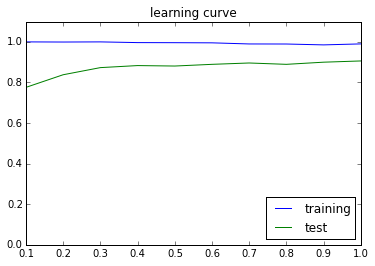

In [24]:
def plot_learning_curve(model_func, dataset):
    from sklearn.learning_curve import learning_curve
    import matplotlib.pyplot as plt
    import numpy as np

    sizes = [i / 10 for i in range(1, 11)]
    train_sizes, train_scores, valid_scores = learning_curve(model_func(), dataset.data, dataset.target, train_sizes=sizes, cv=5)

    take_means = lambda s: np.mean(s, axis=1)
    plt.plot(sizes, take_means(train_scores), label="training")
    plt.plot(sizes, take_means(valid_scores), label="test")
    plt.ylim(0, 1.1)
    plt.title("learning curve")
    plt.legend(loc="lower right")
    plt.show()

plot_learning_curve(make_model, digits)

In [36]:
def show_confusion_matrix(model, dataset):
    from sklearn.metrics import classification_report

    predicted = model.predict(dataset.data)
    target_names = ["#{0}".format(i) for i in range(0, 10)]

    print(classification_report(dataset.target, predicted, target_names=target_names))

show_confusion_matrix(classifier, digits)

             precision    recall  f1-score   support

         #0       0.99      1.00      1.00       178
         #1       0.98      0.95      0.96       182
         #2       0.99      0.98      0.99       177
         #3       0.95      0.99      0.97       183
         #4       1.00      0.99      0.99       181
         #5       1.00      1.00      1.00       182
         #6       1.00      0.99      1.00       181
         #7       1.00      1.00      1.00       179
         #8       0.91      0.98      0.94       174
         #9       1.00      0.96      0.98       180

avg / total       0.98      0.98      0.98      1797

